In [19]:
!pip install keras==1.1.0

  Using cached Keras-1.1.0-py3-none-any.whl
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [1]:
%matplotlib inline
import os
import pandas as pd
os.environ['KERAS_BACKEND'] = 'theano'
import keras
from keras.models import load_model
from keras.preprocessing import sequence
import pickle
import html
import re
from tqdm.notebook import tqdm
from sklearn import preprocessing
import seaborn as sns
from dateutil.tz import tzwin
from datetime import date
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
from nltk.corpus import wordnet 


Using Theano backend.


## Read Twitter Data

In [2]:
CSV_FILENAME = 'tweets2017-2018.csv'
FOLDER = '../Data/Twitter/'

In [3]:
twitter_df = pd.read_csv(os.path.join(FOLDER, CSV_FILENAME))

In [4]:
# Only include english tweets
twitter_df = twitter_df[twitter_df.language == 'en']

In [5]:
twitter_df.head()['tweet']

2    Happy new year all, 2016 was a great year but ...
3    Happy New Year, here from the UK! 2016 was a d...
4    How about a rocky beach? Love this pic! #beach...
5    #HAPPYNEWYEAR It's going to be a whelming one ...
9     https://t.co/KfrKwQFltz #NewYearsEve #Oakland...
Name: tweet, dtype: object

## Convert dates to datetime with a fast converter

In [6]:
twitter_df.index = pd.to_datetime(twitter_df['date'] + ' ' + twitter_df['time'] + ' -0500', format='%Y-%m-%d %H:%M:%S %z')

In [7]:
# Check to make sure our datetime column is a datetime object
twitter_df.index

DatetimeIndex(['2016-12-31 18:59:59-05:00', '2016-12-31 18:59:59-05:00',
               '2016-12-31 18:59:59-05:00', '2016-12-31 18:59:59-05:00',
               '2016-12-31 18:59:59-05:00', '2016-12-31 18:59:59-05:00',
               '2016-12-31 18:59:59-05:00', '2016-12-31 18:59:59-05:00',
               '2016-12-31 18:59:59-05:00', '2016-12-31 18:59:59-05:00',
               ...
               '2018-12-28 18:56:55-05:00', '2018-12-28 18:56:55-05:00',
               '2018-12-28 18:56:55-05:00', '2018-12-28 18:56:55-05:00',
               '2018-12-28 18:56:55-05:00', '2018-12-28 18:56:55-05:00',
               '2018-12-28 18:56:55-05:00', '2018-12-28 18:56:55-05:00',
               '2018-12-28 18:56:55-05:00', '2018-12-28 18:56:55-05:00'],
              dtype='datetime64[ns, pytz.FixedOffset(-300)]', length=10676468, freq=None)

## Filter our Twitter Data

We only want tweets that express emotion and contain ”feel”, ”makes me”, ”I’m” or ”I am”  this will take a while

In [8]:
shortened_df = twitter_df[:6000000]

In [9]:
filtered_df = shortened_df[ 
    shortened_df.tweet.str.contains('feel') |
    shortened_df.tweet.str.contains('makes me') |
    shortened_df.tweet.str.contains('I\'m') |
    shortened_df.tweet.str.contains('I am') 
]

In [10]:
# filtered_df.to_csv(os.path.join(FOLDER, 'filtered_' + CSV_FILENAME))

In [151]:
filtered_df = pd.read_csv(os.path.join(FOLDER, 'filtered_tweets2019-2020.csv'), parse_dates=[0])

In [152]:
filtered_df.set_index('Unnamed: 0', inplace=True)
filtered_df.index.rename('Date', inplace=True)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31 18:59:59-05:00,1079889940933210113,1079889940933210113,2018-12-31 18:59:59 Eastern Standard Time,2018-12-31,18:59:59,-500,1108158768,cerulean_mocha,Aaron C. Southerland,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2018-12-31 18:59:59-05:00,1079889940425658369,1079889940425658369,2018-12-31 18:59:59 Eastern Standard Time,2018-12-31,18:59:59,-500,1853000713,sagedotmuzik,Rich Roach Jr,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2018-12-31 18:59:59-05:00,1079889939788107777,1079889939788107777,2018-12-31 18:59:59 Eastern Standard Time,2018-12-31,18:59:59,-500,188123495,jefflitten,Jeff Litten,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2018-12-31 18:59:59-05:00,1079889938869571584,1079889938869571584,2018-12-31 18:59:59 Eastern Standard Time,2018-12-31,18:59:59,-500,263505287,thethreetwo,3/2,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2018-12-31 18:59:59-05:00,1079889938764779522,1079846904190697473,2018-12-31 18:59:59 Eastern Standard Time,2018-12-31,18:59:59,-500,1003690364941848576,slmumby1,Sheryl Mumby,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'SeanErikAuthor', 'name': ""Se...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-12 18:58:39-05:00,1216509830640340992,1216509830640340992,2020-01-12 18:58:39 Eastern Standard Time,2020-01-12,18:58:39,-500,1081667178498187264,martinezjuarezm,Miguel Martinez Juarez,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2020-01-12 18:58:39-05:00,1216509828299927554,1216509183442350080,2020-01-12 18:58:39 Eastern Standard Time,2020-01-12,18:58:39,-500,1029712525,markhaber713,Mark Haber,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'spencerruchti', 'name': 'Spe...",NaN,NaN,NaN,NaN
2020-01-12 18:58:39-05:00,1216509827981041665,1215940864087773184,2020-01-12 18:58:39 Eastern Standard Time,2020-01-12,18:58:39,-500,992088853468106752,gundudikshitulu,gundudikshitulu,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'RahulGandhi', 'name': 'Rahul...",NaN,NaN,NaN,NaN


## Get Synonyms for the POMS mood words

In [158]:
def get_synonyms(word):
    synonyms = [] 

    for ss in wordnet.synsets(word):
        for lemma in ss.lemma_names():
            synonyms.append(lemma)
    return set(synonyms)

In [159]:
def get_all_synonyms(d, iterations=1):
    for i in range(iterations):
        for key in d.keys():
            base_words = d[key]
            synonyms = []
            for base_word in base_words:
                syns = get_synonyms(base_word)
                for syn in syns:
                    synonyms.append(syn)
            d[key] = list(set(base_words + synonyms))
    return d

In [160]:
poms_dict = {
    'Tension'         : [word.lower() for word in ['Tension', 'Shaky', 'On Edge', 'Panicky', 'Strung Out', 'Uneasy', 'Restless', 'Nervous', 'Anxious']],
    'Depression'      : [word.lower() for word in ['Unhappy', 'Sorry', 'Sad', 'Hopeless', 'Unworthy', 'Discouraged', 'Lonely', 'Miserable', 'Gloomy', 'Desperate', 'Helpless', 'Worthless', 'Terrified', 'Guilty']],
    'Anger'           : [word.lower() for word in ['Anger', 'Peeved', 'Grouchy', 'Spiteful', 'Annoyed', 'Resentful', 'Bitter', 'Ready to Fight', 'Rebellious', 'Deceived', 'Furious', 'Bad Tempered']],
    'Fatigue'         : [word.lower() for word in ['Worn Out', 'Listless', 'Fatigued', 'Exhausted', 'Sluggish', 'Weary', 'Bushed']],
    'Confusion'       : [word.lower() for word in ['Confused', 'Unable to Concentrate', 'Muddled', 'Bewildered', 'Efficient', 'Forgetful', 'Uncertain About Things']],
    'Vigour'          : [word.lower() for word in ['Lively', 'Active', 'Energetic', 'Cheerful', 'Alert', 'Full of Pep', 'Carefree', 'Vigorous']],
}
# poms_dict['Tension']
poms_dict_expanded = get_all_synonyms(poms_dict)

In [161]:
poms_dict_expanded

{'Tension': ['tensity',
  'unquiet',
  'ill_at_ease',
  'tenseness',
  'wobbly',
  'ungratified',
  'uneasy',
  'on edge',
  'shivering',
  'panic-stricken',
  'shaky',
  'trembling',
  'anxious',
  'stress',
  'precarious',
  'frightened',
  'unsatisfied',
  'nervous',
  'neural',
  'panicky',
  'skittish',
  'awkward',
  'dying',
  'aflutter',
  'spooky',
  'rickety',
  'panicked',
  'tautness',
  'terrified',
  'strung out',
  'queasy',
  'flighty',
  'restless',
  'tension',
  'wonky',
  'latent_hostility',
  'panic-struck'],
 'Depression': ['warn',
  'demoralised',
  'despairing',
  'discourage',
  'glooming',
  'undeserving',
  'lone',
  'blue',
  'no-count',
  'sad',
  'unhappy',
  'distressed',
  'heroic',
  'scurvy',
  'pitiful',
  'hapless',
  'terrify',
  'lonely',
  'regretful',
  'depressed',
  'drab',
  'panicked',
  'dysphoric',
  'grim',
  'ugly',
  'misfortunate',
  'pitiable',
  'hangdog',
  'dingy',
  'good-for-nothing',
  'abject',
  'do-or-die',
  'panic-struck',
 

In [162]:
tweets = filtered_df['tweet'].to_list()

In [163]:
dates = pd.date_range(filtered_df.date.min(), filtered_df.date.max()).date.tolist()

In [164]:
def get_word_counts(word_list, tweets_agg):
    d = {}
    total = 0
    for word in word_list:
        count = tweets_agg.count(word)
        d.update({word : count})
        total += count
#     for key in d.keys():
#         d[key] /= total
    d.update({'total_count' : total})
    return d        
    
def calculate_class_scores(poms_dict, tweets_agg, date):
    score_dict = {}
    total_matches = 0
    # Get total matches of all words on a given day
    for key in poms_dict.keys():
        count_dict = get_word_counts(poms_dict[key], tweets_agg)
        total_matches += count_dict['total_count']
    for key in poms_dict.keys():
        total_score = 0
        count_dict = get_word_counts(poms_dict[key], tweets_agg)
        for key1 in count_dict.keys():
            total_score += count_dict[key1]/total_matches
        score_dict.update({key : total_score})
    score_dict.update({'Date' : date})
    return score_dict

tweets_agg = ['. '.join(filtered_df[filtered_df.index.date == dates[10]]['tweet'].astype(str).to_list())][0]
# calculate_word_scores(poms_dict['Depression'], tweets_agg)
calculate_class_scores(poms_dict_expanded, tweets_agg, dates[10])

{'Tension': 0.040345821325648415,
 'Depression': 0.57492795389049,
 'Anger': 0.2968299711815562,
 'Fatigue': 0.42651296829971186,
 'Confusion': 0.53314121037464,
 'Vigour': 0.12824207492795386,
 'Date': datetime.date(2019, 1, 10)}

In [165]:
time_series = []
for date in tqdm(dates):
    agg_tweets = ['. '.join(filtered_df[filtered_df.index.date == date]['tweet'].astype(str).to_list())][0]
    time_series.append(calculate_class_scores(poms_dict_expanded, agg_tweets, date))

In [166]:
df = pd.DataFrame(time_series)

In [167]:
df = df.set_index('Date')

In [168]:
djia_df = pd.read_csv('../Data/DJIA/DJIA.csv', parse_dates=[0], index_col=[0])
merged = df.merge(djia_df, left_index=True, right_index=True)

In [169]:
def scale(df):
    df -= df.min()
    df /= df.max()
    return df
scaled = scale(merged)
scaled.head(2)

,Tension,Depression,Anger,Fatigue,Confusion,Vigour,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,
2018-12-31,0.199039,0.519098,0.516361,0.559851,0.312904,0.463503,0.042584,0.026881,0.077328,0.102260,0.102260,0.096301
2019-01-02,0.208180,0.441180,0.539493,0.288889,0.713221,0.252131,0.026911,0.040647,0.046759,0.105255,0.105255,0.111857


<AxesSubplot:xlabel='Date'>

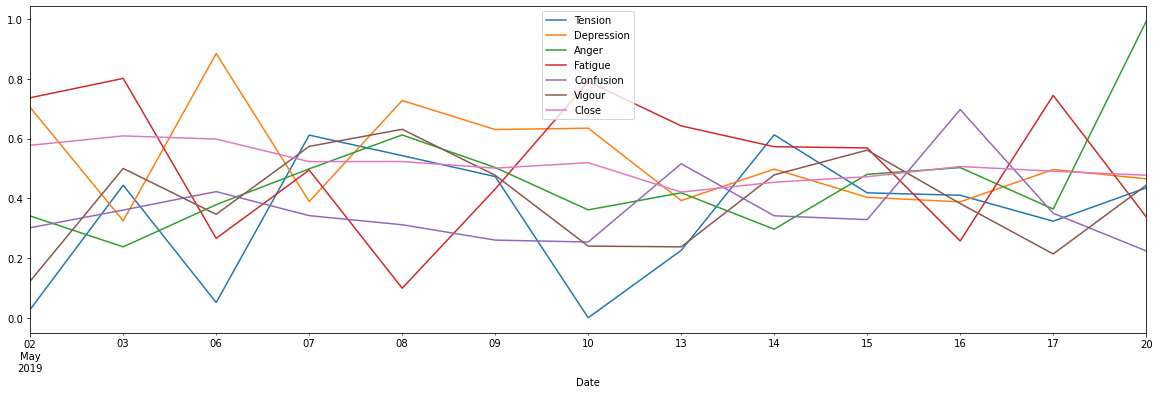

In [213]:
fig, ax = plt.subplots(figsize=(20,6))


startdate = pd.to_datetime('2019-5-2').date()
enddate = pd.to_datetime('2019-5-20').date()
test = scaled[['Tension','Depression', 'Anger', 'Fatigue', 'Confusion', 'Vigour', 'Close']][startdate:enddate]
# test = scaled[['Close', 'Tension']][startdate:enddate]
test.plot(ax=ax)


In [179]:
merged.to_csv('../Data/EmotionMetrics/poms_scratch_2019-2020v2.csv')


In [176]:
def get_granger_causality(df_list, model_names, lag_limit):
    l = []
    assert(len(df_list) == len(model_names))
    for i in range(len(df_list)):
        df = df_list[i]
        model_name = model_names[i]
        emotions = df.drop(['Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], axis=1).columns
        for emotion in emotions:
            test_data = df[['Close', emotion]].pct_change().replace([np.inf, -np.inf], np.nan).dropna()
            gc_res = grangercausalitytests(test_data, lag_limit, verbose=False)
            for key in gc_res:
                d = {'model_name'      : model_name,
                     'emotion'         : emotion,
                     'lags'            : key,
                     'ssr_ftest_p'     : gc_res[key][0]['ssr_ftest'][1], 
                     'ssr_chi2test_p'  : gc_res[key][0]['ssr_chi2test'][1], 
                     'lrtest_p'        : gc_res[key][0]['lrtest'][1], 
                     'params_ftest_p'  : gc_res[key][0]['lrtest'][1]}
                l.append(d)
    return pd.DataFrame(l)

In [177]:
analysis = get_granger_causality([merged], ['POMS'], 5).sort_values(by='ssr_ftest_p')

In [178]:
analysis

,model_name,emotion,lags,ssr_ftest_p,ssr_chi2test_p,lrtest_p,params_ftest_p
3,POMS,Tension,4,0.016264,0.011959,0.013710,0.013710
4,POMS,Tension,5,0.044621,0.033565,0.037490,0.037490
1,POMS,Tension,2,0.058304,0.053283,0.055082,0.055082
2,POMS,Tension,3,0.132041,0.120383,0.123872,0.123872
8,POMS,Depression,4,0.282517,0.261091,0.266248,0.266248
7,POMS,Depression,3,0.284113,0.269357,0.272711,0.272711
0,POMS,Tension,1,0.340638,0.336879,0.337314,0.337314
9,POMS,Depression,5,0.355843,0.326030,0.332804,0.332804
12,POMS,Anger,3,0.459313,0.445077,0.447474,0.447474
13,POMS,Anger,4,0.478546,0.457551,0.461381,0.461381


## Import EmotionPredictor library

Import EmotionPredictor library which is a library that will do a sentiment analysis with three different models with different emotional predictors. These keras models were pre-trained, so we only need to load the models and create analysis data on our twitter data

We will use three pre-trained models each with their own emotion features:
poms
ekman
plutchik

In [23]:
from emotion_predictor import EmotionPredictor

In [24]:
poms_model = EmotionPredictor(classification='poms', setting='mc', use_unison_model=True)
ekman_model = EmotionPredictor(classification='ekman', setting='mc', use_unison_model=True)
plutchik_model = EmotionPredictor(classification='plutchik', setting='mc', use_unison_model=True)

ValueError: Unknown layer: Merge

## Get a list with each date

Now that our models are loaded, we need to create a new dataframe for each model that will have analysis for each date in our twitter dataframe

In [9]:
dates = pd.date_range(twitter_df.date.min(), twitter_df.date.max()).date.tolist()

In [10]:
# Check to make sure we only have individual dates
dates[:10]

[datetime.date(2018, 12, 31),
 datetime.date(2019, 1, 1),
 datetime.date(2019, 1, 2),
 datetime.date(2019, 1, 3),
 datetime.date(2019, 1, 4),
 datetime.date(2019, 1, 5),
 datetime.date(2019, 1, 6),
 datetime.date(2019, 1, 7),
 datetime.date(2019, 1, 8),
 datetime.date(2019, 1, 9)]

In [15]:
tweets = twitter_df[:10]['tweet'].to_list()

In [16]:
poms_model.predict_classes(tweets)
    

NameError: name 'poms_model' is not defined

# Create a list of dicts for each model
Our EmotionPredictor models will produce a dataframe with proportions for each emotions detected in the text. We want to create an aggregate string that has all of the tweets created on a particular date, and feed it to the predictive model as input. The output is a DataFrame, which we can take the first row, and convert it to a dictionary, which we can then add the date to, and append to each list. This is the fastest way to process the data.

In [ ]:
poms_l, ekman_l, plutchik_l = [], [], []
for date in tqdm(dates):
    # Aggregate all the tweets on a particular date
    tweets = ['. '.join(twitter_df[twitter_df.index.date == date]['tweet'].astype(str).to_list())]
    if(tweets == ['']):
        print('No tweets on date', date)
    # Feed it into the model, convert to dictionary
    d = poms_model.predict_probabilities(tweets).iloc[0].to_dict()
    # Add the date to the dictionary
    d['Date'] = date
    # Append to the list, repeat for each model
    poms_l.append(d)
    d = ekman_model.predict_probabilities(tweets).iloc[0].to_dict()
    d['Date'] = date
    ekman_l.append(d)
    d = plutchik_model.predict_probabilities(tweets).iloc[0].to_dict()
    d['Date'] = date
    plutchik_l.append(d)
    
    

# Create a DataFrame for each list of dicts
As you can see from the DataFrame below, our emotional models have predicted proportions of emotions for each aggregated twitter data on a specified consecutive date. 

In [ ]:
poms_df = pd.DataFrame(poms_l)
ekman_df = pd.DataFrame(ekman_l)
plutchik_df = pd.DataFrame(plutchik_l)

In [ ]:
poms_df.head()

In [ ]:
poms_df['Date'] = pd.to_datetime(poms_df.Date)
ekman_df['Date'] = pd.to_datetime(ekman_df.Date)
plutchik_df['Date'] = pd.to_datetime(plutchik_df.Date)

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
# poms_df['Tension'].plot()
ekman_df['Anger'].plot(ax=ax)
# plutchik_df['Anger'].plot()

## Now import the DJIA data
We want to compare our generated emotion data with the DJIA by performing a Granger Causality Analysis on each emotion to discover if the moods of the public as represented on twitter has an effect on stock prices

In [ ]:
djia_df = pd.read_csv('../Data/DJIA/DJIA.csv', parse_dates=[0])

In [ ]:
djia_df

In [ ]:
# Merge the DJIA DataFrame with each of our generated emotion DataFrames
poms_merged = poms_df.merge(djia_df, left_on='Date', right_on='Date')
ekman_merged = ekman_df.merge(djia_df, left_on='Date', right_on='Date')
plutchik_merged = plutchik_df.merge(djia_df, left_on='Date', right_on='Date')

In [ ]:
poms_merged.Date.max()

## Granger Causality Analysis
Perform Granger Causality test on each of the emotions, and determine if any of the tests have a P-value < 0.05

In [ ]:
def get_granger_causality(df_list, model_names, lag_limit):
    l = []
    assert(len(df_list) == len(model_names))
    for i in range(len(df_list)):
        df = df_list[i]
        model_name = model_names[i]
        emotions = df.drop(['Tweet', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], axis=1).columns
        for emotion in emotions:
            test_data = df[['Close', emotion]].pct_change().dropna()
            gc_res = grangercausalitytests(test_data, lag_limit)
            for key in gc_res:
                d = {'model_name'      : model_name,
                     'emotion'         : emotion,
                     'lags'            : key,
                     'ssr_ftest_p'     : gc_res[key][0]['ssr_ftest'][1], 
                     'ssr_chi2test_p'  : gc_res[key][0]['ssr_chi2test'][1], 
                     'lrtest_p'        : gc_res[key][0]['lrtest'][1], 
                     'params_ftest_p'  : gc_res[key][0]['lrtest'][1]}
                l.append(d)
    return pd.DataFrame(l)

In [ ]:
df_list, model_names = [poms_merged, ekman_merged, plutchik_merged], ['POMS', 'Ekman', 'Plutchik']
gc_results = get_granger_causality(df_list, model_names, lag_limit=7)

In [ ]:
gc_results.sort_values(by='ssr_chi2test_p').head(40)

In [ ]:
def plot_highest_correlation(df_list, model_names, gc_results, limit, sort_by):
    lookup = {key: val for key, val in zip(model_names, df_list)}
    gc_results = gc_results.sort_values(by=sort_by)
    scaler = preprocessing.MinMaxScaler()
    x = df_list[0]['Close']
    close_series = (x-min(x))/(max(x)-min(x))
    for index, row in gc_results.head(limit).iterrows():
        model_name = row['model_name']
        emotion = row['emotion']
        lag = row['lags']
        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(f'{model_name} {emotion} versus DJIA with lag {lag} days with {sort_by}={"%.5f" % row[sort_by]}')
        lookup[row['model_name']][row['emotion']].plot()
        close_series.plot(ax=ax)

In [ ]:
plot_highest_correlation(df_list, model_names, gc_results, limit=40, sort_by='ssr_chi2test_p')

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
TEST_DF[EMOTION].plot()
close_series.plot(ax=ax)

## Granger Analysis Results
After performing Granger Causality Analysis on each of the emotions, it was discovered that only the POMS Depression and POMS Tension features rejected the null hypothesis after a 6 day lag. When compared to a similar analysis (https://arxiv.org/pdf/1010.3003&, Bollen), the results found in our model correspond directly with the results found in Bollen's analysis. Bollen uses the Google-Profile of Mood States model (Calm, Alert, Sure, Vital, Kind, and Happy), which is the opposite of our Profile of Mood States model (Tension, Fatigue, Confusion, Vigour, Anger, and Depression), with the exception of Vigour, which is the same as Vitality. Bollen found that Calmness (Tension) and Happiness (Depression) were the two biggest predictors of DJIA, which aligns perfectly with our analysis.

In [333]:
# ekman_merged.drop(['Tweet'], axis=1).to_csv('../Data/EmotionMetrics/test2019-2020.csv')
# ekman_merged.drop(['Tweet', 'Date'], axis=1).pct_change().to_csv('../Data/EmotionMetrics/pct_test2019-2020.csv')
plutchik_merged.drop(['Tweet'], axis=1).to_csv('../Data/EmotionMetrics/plutchik_2019-2020.csv')


In [330]:
plutchik_merged

,Tweet,Anger,Disgust,Fear,Joy,Sadness,Surprise,Trust,Anticipation,Date,Open,High,Low,Close,Adj Close,Volume
0,@vincegarin @SininStyle @jackallisonLOL Me too...,0.007864,0.001715,0.011018,0.920897,0.017993,0.005999,0.034289,0.000224,2018-12-31,23153.939453,23333.179688,23118.300781,23327.460938,23327.460938,288830000
1,I liked a @YouTube video https://t.co/Q8r6vk7...,0.003853,0.001463,0.043744,0.034117,0.008783,0.027913,0.879042,0.001085,2019-01-02,23058.609375,23413.470703,22928.589844,23346.240234,23346.240234,321570000
2,I posted a new video to Facebook https://t.co...,0.007961,0.000013,0.039217,0.892343,0.000309,0.001695,0.057505,0.000957,2019-01-03,23176.390625,23176.390625,22638.410156,22686.220703,22686.220703,424240000
3,@chicagobulls This joke of a person thinks thi...,0.002670,0.000475,0.063315,0.192534,0.001582,0.005535,0.732530,0.001360,2019-01-04,22894.919922,23518.640625,22894.919922,23433.160156,23433.160156,396020000
4,"If you are having a bad day, word of advice pl...",0.009684,0.003197,0.044377,0.088861,0.002096,0.001968,0.842027,0.007791,2019-01-07,23474.259766,23687.740234,23301.589844,23531.349609,23531.349609,334200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,I want a salmon caesar salad or salmon alfredo...,0.014846,0.002599,0.032207,0.667670,0.034274,0.042091,0.192487,0.013827,2019-12-09,27987.050781,28010.419922,27906.140625,27909.599609,27909.599609,217000000
238,Starts a thread. One tweet later: https://t.c...,0.101075,0.020757,0.102439,0.366778,0.008708,0.346969,0.047641,0.005634,2019-12-10,27900.650391,27949.019531,27804.000000,27881.720703,27881.720703,213250000
239,I’m going to be a tattoo artist. Using a propr...,0.000230,0.000003,0.005106,0.077308,0.000147,0.001155,0.914763,0.001290,2019-12-11,27867.310547,27925.500000,27801.800781,27911.300781,27911.300781,213510000
240,How to troll a bully 101 🤣🤣🤣👍🏻👏 https://t.co/...,0.125928,0.049147,0.053682,0.189497,0.012310,0.023286,0.544874,0.001276,2019-12-12,27898.339844,28224.949219,27859.869141,28132.050781,28132.050781,277740000
